# Quantum Kernel Estimator Challenge

For the first leg of the QML challenge, you implemented a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Now, you will build on that experience, and explore Havlicek et al.'s second proposed method of applying quantum-enhanced feature spaces to machine learning: the *quantum kernel estimator*. In this challenge continuation, you will construct a QML model that estimates a kernel function using a quantum computer and optimize a classical support vector machine (SVM). For this classification protocol, we will continue to restrict ourselves to the binary label case, with $C = \left\{+1, −1\right\}$.

Compared to the VQC challenge, we are providing very little template code for this kernel estimator challenge. This is by design to enable teams to further differentiate their model, especially in the training phase. The [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf) paper is your best resource, and the [Kernel-based training Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html) may also be helpful. You are free to import and use any additional packages that you wish.

### second submission update changes:
1) kernel arrow and i fixed, previously not correct, and change final kernel colormap, for better view.
2) add more explanation after tried other possible better algorithm
3) add visualization, Decision Binary Boundary

In [1]:
!qbraid jobs enable haqs  # enable quantum jobs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [2]:
TEAM_NAME = "poig"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations
from functools import partial
import copy

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
import pennylane.numpy as np
import numpy as numpy
from tqdm.notebook import tqdm

from scipy.optimize import minimize

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
save_result = True #set if want to save the running result
notebook_start = time.time()

## Load and visualize dataset

As before, we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \in \rm {I\!R}^n$. Both are assumed to be labelled by the map $m: T \cup S \rightarrow \{+1, −1\}$ unkown to the algorithm. To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

In [5]:
%run gen_binary.py  # uncomment to generate new train/test dataset

In [6]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, train_size=1 / n_sets
)

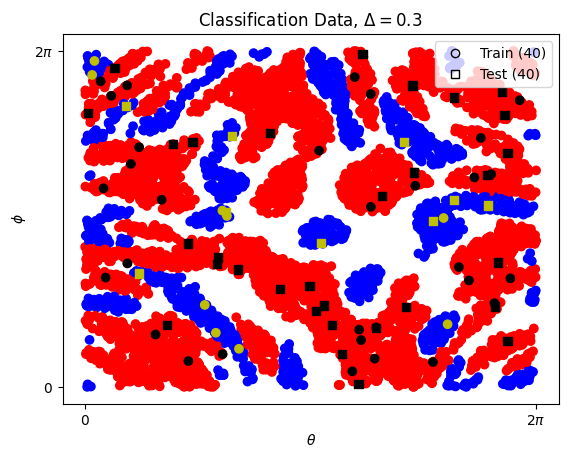

In [7]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()

The data: To test our two methods, we generate artificial data that can be fully separated by our feature map. We use the map with the `encode_data(x)` function descript below.  
 We generate the labels for data vectors $\overrightarrow{x} \in T \cup S \subset (0,2\pi]^{2}$,by first choosing $\mathbf{f} = Z_1Z_2$ as the parity function and a random 4x4 unitary $V\in SU(4)$.  
We assign:
$$ \overrightarrow{x} \mapsto \Bigg\{\begin{array}{ll}
    m(\overrightarrow{x})=+1 & \mbox{if}\ \langle\phi(\overrightarrow{x})|V^{\dagger} fV | \phi (\overrightarrow{x})\rangle \geq \Delta  \\
        m(\overrightarrow{x})=-1 & \mbox{if}\ \langle\phi(\overrightarrow{x})|V^{\dagger} fV | \phi (\overrightarrow{x})\rangle \leq -\Delta 
    \end{array}$$
The data has been separated by a gap of $\Delta = 0.3$. Both the training set and testing set consist of 40 data points.

### Embadding circuit (Feature map) 
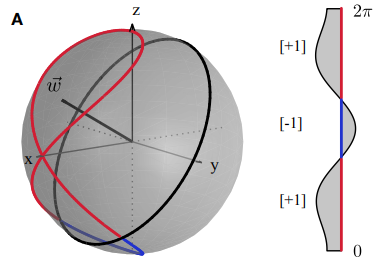  
Feature map representation for a single qubit. A classical dataset in the interval Ω = (0, 2π] with binary labels (a, right) can be mapped onto the Bloch sphere (red / blue - lines) by using the non-linear feature map described in below.

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

encode data can be written as:
$$\phi_S:x\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ X=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ X=\{i,j\}
    \end{array}$$.


In [8]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [9]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$    
$$U_{\Phi(\mathbf{x})} = \left(H^{\otimes n} \, \exp\left(i\sum_k \phi_{\{k\}}(\mathbf{x})\, Z_k\right) \, \exp\left(i\sum_{kl} \phi_{\{k,l\}}(\mathbf{x}) \, Z_k \otimes Z_l\right) \right)^d$$ 

In [10]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [11]:
def embedding(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """
    # TODO
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(-2 * x[0], wires=0)
    qml.RZ(-2 * x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * x[2], wires=1)
    qml.CNOT(wires=[0, 1])

## Quantum kernel $K$ (ideal)
### kernel (Construct Device and Circuit)

In [12]:
dev_kernel = qml.device("default.qubit", wires=n_wires)

# https://quantumcomputing.stackexchange.com/questions/17868/quantum-circuit-for-the-zz-feature-map
projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x, z):
    """Compute quantum kernel element for two feature vectors.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """
    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        embedding(x_enc)
    qml.Barrier()
    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
    
    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

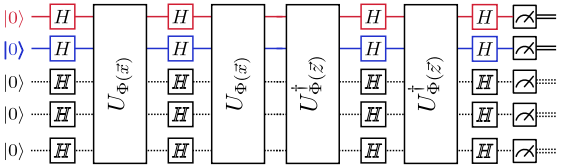

In [13]:
qnode_local = qml.QNode(kernel, dev_kernel)
print(X_train[0])
print(qml.draw(qnode_local)(X_train[0],X_train[0]))  # example parameterized circuit
print(qnode_local(X_train[0],X_train[0]))

[1.97515688 3.19544389]
0: ──H──RZ(-3.95)─╭●───────────╭●──H──RZ(-3.95)─╭●───────────╭●──||─╭●─────────────╭●───RZ(-3.95)†
1: ──H──RZ(-6.39)─╰X──RZ(0.13)─╰X──H──RZ(-6.39)─╰X──RZ(0.13)─╰X──||─╰X†──RZ(0.13)†─╰X†──RZ(-6.39)†

───H†─╭●─────────────╭●───RZ(-3.95)†──H†─┤ ╭<𝓗(M0)>
───H†─╰X†──RZ(0.13)†─╰X†──RZ(-6.39)†──H†─┤ ╰<𝓗(M0)>
0.9999999999999978


### kernel_ideal (Construct Kernel)

In [14]:
def kernel_ideal(A, B):
    """Ideal kernel matrix for sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

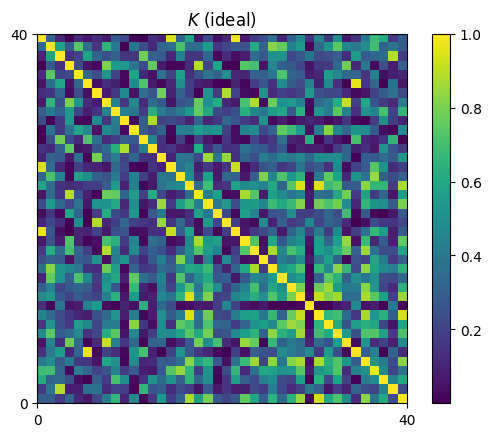

In [15]:
# Visualize ideal kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (right)
k_ideal = kernel_ideal(X_train, X_train)

im = plt.imshow(k_ideal, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (ideal)")
plt.show()

### Computer Accuracy

In [16]:
svm = SVC(kernel=kernel_ideal).fit(X_train, Y_train)
predictions = svm.predict(X_test)
print(f'test accuracy: {accuracy_score(predictions, Y_test)*100}%')

test accuracy: 97.5%


## Quantum kernel estimator

Here it will be convenient to write $T = \left\{\textbf{x}_1,...,\textbf{x}_t\right\}$ with $t = \left|T\right|$; also let $y_i = m(\textbf{x}_i)$ be the corresponding label. In this protocol you will use a quantum computer to estimate the $t \times t$ kernel matrix $K(\textbf{x}_i, \textbf{x}_j) = \left|\langle\Phi(\textbf{x}_i)|\Phi(\textbf{x}_j)\rangle\right|^2$. For all pairs of points $\textbf{x}_i, \textbf{x}_j \in T$ in the the training data, you will sample the overlap between feature states to obtain the matrix entry in the kernel. This fidelity can be estimated from the output probability of the circuit by sampling the output distribution with $R$ shots and only taking the $0^n$ count. The frequency of the $0^n$ count is an estimator of the Kernel entry up to an error $\epsilon = O(R^{−1/2})$. After the kernel matrix for the full training data has been constructed we use the conventional (classical) support vector machine classifier. The optimal hyperplane can be found by solving the dual quadratic program $L_D$ for the variables $\alpha = \left\{\alpha_i\right\}_{i=1...t}$. Hence, to train, we maximize

\begin{equation}
L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\textbf{x}_i, \textbf{x}_j),
\label{eq:Ld} \tag{1}
\end{equation}

subject to $\sum_{i=1}^t \alpha_i y_i = 0$ and $\alpha_i \geq 0$. This problem is concave, and therefore efficiently solvable, whenever $K(\textbf{x}_i, \textbf{x}_j)$ is a positive definite matrix. Standard quadratic programming solvers can be used. The solution to this problem will be given by a nonnegative vector $\alpha^* = (\alpha_1^*,...,\alpha_t^*)$. Due to complementary slackness, we expect that many of the $\alpha_i^*$ will be zero. Hence, there will only be subset of training samples that are needed to construct the optimal hyperplane. These samples are referred to as the support vectors.

The training phase consists of the following steps:

---
### Algorithm 1: training
1. **Input** Labeled training samples $T = \left\{ \textbf{x} \in \Omega \in {\rm I\!R}^n \right\} \times \left\{ y \in C \right\}$, quadratic program solver.
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ **do**
5. $\hspace{5mm}$ **for** $\textit{j} = 1$ to $\textit{t}$ **do**
6. $\hspace{10mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{10mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{15mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{x}_j$.
9. $\hspace{15mm}$ Measure outcome in $Z$-basis.
10. $\hspace{15mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{20mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{15mm}$ **end if**
13. $\hspace{10mm}$ **end for**
14. $\hspace{10mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{x}_j) = r_{0^n}R^{-1}$.
15. $\hspace{5mm}$ **end for**
16. **end for**
17. Use quadratic program solver to optimize $\alpha$ in $L_D$ in eqn. (1) with kernel $K = \hat{K}$ and set $T$.
18. **return** the final parameters $\alpha^*$ and value of the cost function $L_D$ and kernel estimator $\hat{K}$.
---

## Quantum kernel $\hat K$  (Experimental)
### fidelity_estimation (Construct Device and Circuit)

In [17]:
shots = 50_000 #as paper mention, but because we are not using noise backend, we can use lesser shots, for saving some time, 
               #but we can increase shots to increase accuracy, it can even better than ideal

dev_est = qml.device("default.qubit", wires=n_wires, shots=shots)
@qml.qnode(dev_est)
def fidelity_estimate(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    # TODO (hint: Havlicek Fig. 2.c.)
    # Circuit is the same as ZZ-feature map
    x_enc = encode_data(x)
    z_enc = encode_data(z)
    for _ in range(S_size):
        embedding(x_enc)
    qml.Barrier()
    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
    
    return qml.counts(all_outcomes=False)

In [18]:
print(X_train[0])
#print(qml.draw(qml.QNode(fidelity_estimate, dev_est))(X_train[0],X_train[0]))
print(fidelity_estimate(X_train[0],X_train[0]))

[1.97515688 3.19544389]
{'00': 50000}


Example parameterized circuit draw, not avaliable with `qml.counts()`, change it to `qml.state()` and uncomment the second line of code above to print.  
because we embedding the same dataset this should give `{'00': 50000}`, without noise.

### kernel_experimental (Construct Kernel)

In [19]:
def kernel_experimental(A: np.ndarray, B: np.ndarray = None,alpha=None) -> np.ndarray:
    """Experimentally estimated kernel matrix for sets A and B.
    Args:
        A : labels (txt)
        B : labels (txt)
        alpha : alpha from quadratic equation
    
    Output:
        alpha : the calculated solution vector (txt)
    """
    # TODO: Implement training algorithm
    
    # step1, determine if calculating self inner product
    is_symmetric = True
    if B is None:
        B = A
    elif not np.array_equal(A, B):
        is_symmetric = False

    # step6, initialize kernel matrix
    kernel = np.zeros((A.shape[0], B.shape[0]))
    
    #step4, loop i to t
    for i in range(A.shape[0]):
        #step5, loop i to t
            for j in range(B.shape[0]):
                #step6, set counter = 0
                counter = 0
                # run shots if it is symmetric or alpha > 0
                if is_symmetric or alpha[i] > 0:
                    #step7-9, loop through shots
                    result = fidelity_estimate(A[i],B[j])
                    #step 10-11, measure out the 0 from shots
                    counter = result.get("0" * n_wires, 0)
                #step14, construct kernel estimator
                kernel[i, j] = counter
                # if it is symmetric we want both side the same
                if is_symmetric:
                    kernel[j, i] = kernel[i, j]
    if is_symmetric:
            # Find the closest positive semi-definite approximation to symmetric kernel matrix.
            # The (symmetric) matrix should always be positive semi-definite by construction,
            # but this can be violated in case of noise, such as sampling noise, thus the
            # adjustment is only done if NOT using the statevector simulation.
            D, U = np.linalg.eig(kernel)  # Compute the eigenvalues and right eigenvectors of a square array.
            kernel = U @ np.diag(np.maximum(0, D)) @ U.transpose()
    return kernel

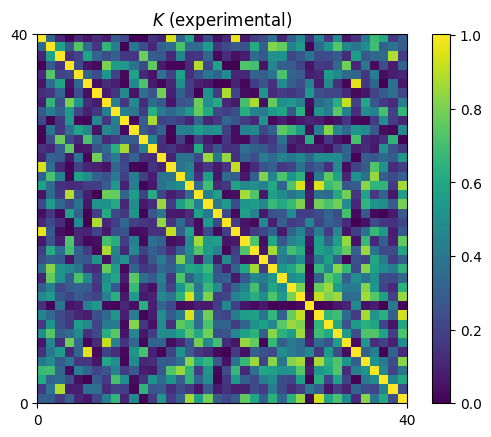

problem status: optimal
run time: 0.0018s
number of total alpha: 40
number of optimal alpha: 20
Time elapsed: 154.44088006019592s


In [20]:
# step17, we run quadratic equation
!pip install cvxpy==1.2.1 -q

import cvxpy as cp
from docplex.mp.model import Model
        
def dualqp(K,A,C):
    """
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Args:
        K : the (txt) kernel matrix
        A : training labels (tx1)
        C : the SVM regularization parameter
    
    Output:
        alpha : the calculated solution vector (tx1)
    """
    # create tx1 number of variable, maybe can get nicer solution with nonneg
    alpha = cp.Variable(shape=K.shape[0])#,nonneg=True) #nonneg maybe can get better result
    
    # define the kernel parameter
    K_ = cp.Parameter(shape=K.shape, PSD=True, value=K)
    
    #the loss function (1)
    obj = cp.Maximize((numpy.ones(alpha.shape).T @ alpha) - (0.5 * cp.quad_form(cp.multiply(alpha, A), K_)))
    
    # the subject to (constaints)
    constraints = [alpha>=0, cp.sum(cp.multiply(A, alpha))==0]
    
    # optional for better result, suggest C=10
    if C != None:
        C1 = Parameter(nonneg=True)
        C1.value=C
        constraints.append(alpha<=C1)
    # construct problem
    prob = cp.Problem(obj, constraints)
    
    # start solving the problem
    prob.solve()
    print(f"problem status: {prob.status}")
    print(f"run time: {round(prob._solve_time,4)}s")
    
    #return output
    return numpy.array(alpha.value).flatten(), prob.value

start = time.time()
# compute kernel (make sure it is PSD(positive semi-definite))
k_exp = kernel_experimental(X_train)

# plot kernel matrix
im = plt.imshow((k_exp/shots), extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (experimental)")
plt.show()

# constructs the SVM dual formulation and uses a built-in 
# convex solver to find the optimal solution. 
alpha, opt_value= dualqp(numpy.array(k_exp),numpy.array(Y_train),None)# solver- cvxpy,cplex
print("number of total alpha:", alpha.shape[0])

# Prune kernel matrix of non-support-vector entries
opt_alpha = alpha[(alpha > 0).flatten()]
print("number of optimal alpha:",opt_alpha.shape[0])
print(f"Time elapsed: {time.time() - start}s")

Used cvxpy open sources optimizer to solved the QP problem.  
Unfortunately qiskit admm optimizer is infeasible to the loss function, otherwise we might can get much better alpha.

### Save Loss Function Result

In [21]:
#print the final output
print("Final parameters", opt_alpha, "\n\nValue of the cost function:", opt_value,"\n\nKernel estimator:", k_exp)

if save_result == True:
    # create folder and save the result
    time_str = time.strftime("%Y%m%d-%H%M%S")
    QKE_OUT = f"QKE/{time_str}"
    os.makedirs(QKE_OUT, exist_ok=True)
    
    # saving file
    params_csv = f"{QKE_OUT}/{TEAM_NAME}_alpha.csv"
    np.savetxt(params_csv, alpha)
    print(f"\nParameters saved to {params_csv}")
    
    costs_csv = f"{QKE_OUT}/{TEAM_NAME}_shots&costs&bias.csv"
    np.savetxt(costs_csv, [shots,opt_value])
    print(f"Costs saved to {costs_csv}")
    
    kernel_csv = f"{QKE_OUT}/{TEAM_NAME}_kernel.csv"
    np.savetxt(kernel_csv, k_exp)
    print(f"Kernel saved to {kernel_csv}")

Final parameters [1.76155709e-11 2.53368549e-05 8.55097865e-05 3.28315213e-10
 2.41759246e-05 1.50192593e-10 9.45255551e-11 2.04964401e-05
 3.91115513e-05 1.92647007e-10 6.19215062e-06 7.63632106e-05
 1.74611762e-10 1.54476078e-10 7.06979916e-11 3.49948467e-10
 2.46663218e-06 5.16074370e-06 7.76885310e-05 4.44054323e-05] 

Value of the cost function: 0.00020345209866036074 

Kernel estimator: [[50118.93909895 16669.66313559  5338.1730364  ... 30661.60235954
   8335.00865492 14929.09929672]
 [16669.66313559 50136.3378064  28915.52775987 ... 15544.73565971
  19169.1361975  14705.74387595]
 [ 5338.1730364  28915.52775987 50151.27723304 ... 17669.24845051
  44230.2060323   8728.2703766 ]
 ...
 [30661.60235954 15544.73565971 17669.24845051 ... 50150.05169597
  22541.9930643  30333.40802617]
 [ 8335.00865492 19169.1361975  44230.2060323  ... 22541.9930643
  50072.60603445 11937.27807327]
 [14929.09929672 14705.74387595  8728.2703766  ... 30333.40802617
  11937.27807327 50131.07230918]]

Para

In the classification phase, we want to assign a label to a new datum $s \in S$ of the test set. For this, the inner products $K(\textbf{x}_i, \textbf{s})$ between all support vectors $\textbf{x}_j \in T$ with $\alpha_i^* > 0$ and the new datum s have to be estimated on the quantum computer, c.f. Havlicek Fig. S5.b. The new label $\tilde{m}(\textbf{s})$ for the datum is assigned according to Havlicek eqn. (14). Since all support vectors are known from the training phase and we have obtained access to the kernel $K(\textbf{x}_i,\textbf{s})$ from the quantum hardware, the label can be directly computed according to


\begin{equation}
\tilde{m}(\textbf{s}) = \text{sign} \bigg(\sum_{i=1}^t y_i \alpha_i^* K(\textbf{x}_i, \textbf{s}) + b \bigg).
\label{eq:ms} \tag{2}
\end{equation}

Note that the bias $b$ in $\tilde{m}(\textbf{s})$ can be calculated from the weights $\alpha_i^*$ by choosing any $i$ with $\alpha_i^* > 0$ and solving $\sum_j y_j \alpha_j^* K(\textbf{x}_j, \textbf{x}_i) + b = y_i$ for $b$.

---
## Algorithm 2: classification
1. **Input** An unlabeled sample from the test set $\textbf{s} \in S$, optimal SVM parameters $\alpha, b$ and training data set $T$. 
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ with $\alpha_i^* > 0$ **do**
5. $\hspace{5mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{5mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{10mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{s}$.
9. $\hspace{10mm}$ Measure outcome in $Z$-basis.
10. $\hspace{10mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{15mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{10mm}$ **end if**
13. $\hspace{5mm}$ **end for**
14. $\hspace{5mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{s}) = r_{0^n}R^{-1}$.
15. **end for**
16. **return** $\text{sign}\big(\sum_{i=1}^t y_i \alpha_i^* \hat{K}(\textbf{x}_i, \textbf{s}) + b \big)$.
---

$$
b = y_i -  \sum_{i=1}^t y_j \alpha_j^* K(\textbf{x}_j, \textbf{x}_i)
$$

### Format loss function

In [22]:
def recoverBias(K,B,alpha,C):
    """
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with smallest alpha values
    
    Args:
    K : txt kernel matrix
    B : 1xt input labels
    alpha  : nxt vector of alpha values
    C : regularization constant
    
    Output:
        bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """
    # find the minimum alpha position
    idx = np.argmin(np.abs(alpha - (C/2)))
    # inverse calculate the bias equation(3)
    b=B[idx]- np.sum(np.multiply(np.multiply(B,alpha),K[:,idx]))
    return b

In [23]:
def dualSVM(A,B,C,alpha,bias):
    """
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        A : training data (txd)
        B : training labels (tx1)
        C : the SVM regularization parameter
        alpha : optimal alpha
        bias : calculated bias
    
    Output:
        svmclassify : usage: predictions=svmclassify(X_test)
    """
    
    K = lambda x : kernel_experimental(X_train, x, alpha)
    
    ytrlpha = np.multiply(B,alpha)
    # step 4-15 do the same in algo 1, and use classifier equation(2) 
    svmclassify1 = lambda x: np.sign(bias + np.dot(ytrlpha, K(x)))
    return svmclassify1

In [24]:
start = time.time()

# TODO: Implement classification algorithm

# calculate bias with alpha that is bigger than 0 
S = (alpha > 0).flatten()
bias = recoverBias(k_exp[S],Y_train[S],alpha[S],0)
print('bias:',bias)
# save it into file
if save_result == True: np.savetxt(costs_csv, [shots,opt_value,bias])

# return lambda loss function 
svmclassify=dualSVM(numpy.array(X_train),numpy.array(Y_train),0,alpha, bias)

bias: 0.17786247515115639


### Computer Accuracy

In [25]:
# compute train accuracy, to check how well bias and alpha work, from smallest error 0.0000 to 1.0000
pred1 =svmclassify(X_train)
trainingerr=np.mean(pred1!=Y_train)
print("Training error: %2.4f" % trainingerr)

# TODO: Test accuracy
predsTe=svmclassify(X_test)
preds1Te = [1 if predsTe[i] == Y_test[i] else 0 for i in range(len(predsTe))]
acc=sum(preds1Te)/ len(preds1Te)*100
print(f"Test Accuracy: {acc}%")

#total time taken
print(f"Time elapsed: {time.time() - start}s")

Training error: 0.0000
Test Accuracy: 100.0%
Time elapsed: 231.93570041656494s


## Visualize Result

### Plot Result

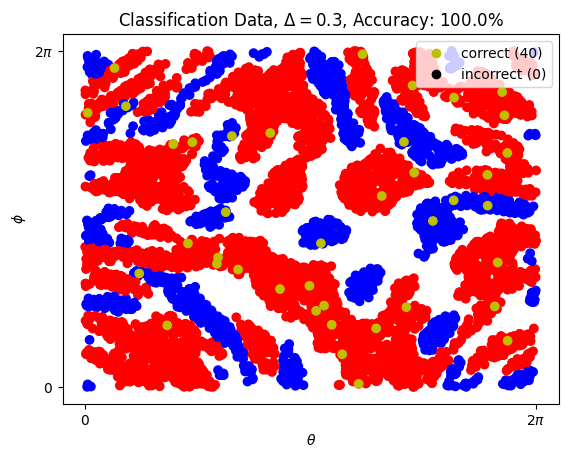

In [26]:
label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="y",
    markeredgecolor="y",
    label=f"correct ({sum(preds1Te)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    label=f"incorrect ({preds1Te.count(0)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_test, xj_test, c=["y" if v == 1.0 else "k" for v in preds1Te])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$, Accuracy: {acc}%")
#save image
if save_result == True: plt.savefig(f"{QKE_OUT}/{TEAM_NAME}_preds.png")
plt.show()

### Maximal deviation (mention in paper fig 4)

i,j = 13,31


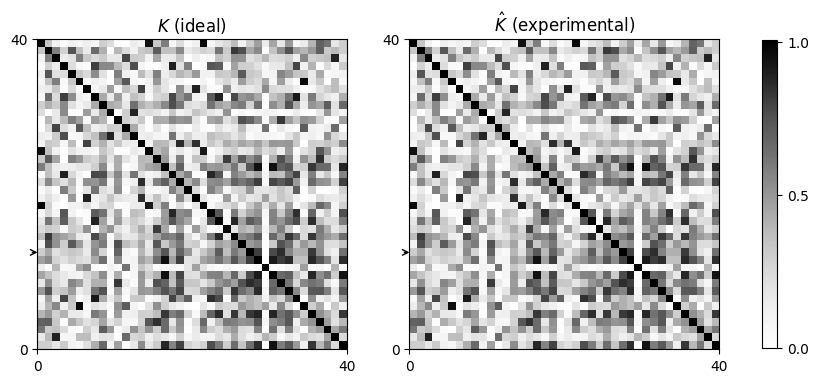

In [27]:
def max_dev(A,B):
    """
    calculate maximal deviation |A − B| of two matrix,
    simply mean it will find the maximal differences between two matrix row.
    
    Input:
        A : kernel matrix (txt)
        B : kernel matrix (txt)
    
    Output:
        maximal deviation
    """
    abs_dif = abs(A - B)
    abs_max = np.max(abs_dif,axis=0)
    max_dev = np.argmax(abs_max,axis=0)
    print(f"i,j = {40-max_dev},{np.argmax(abs_dif[max_dev],axis=0)}")
    return max_dev
i= max_dev(copy.deepcopy(k_exp)/shots, copy.deepcopy(k_ideal))

# create plot
fig, axs = plt.subplots(1, 2, figsize=(11,5))
plt.setp(axs, xticks=[0, samples_per_set], yticks=[0, samples_per_set])

# plot kernel and arrow
for ax, title, A in zip(axs, ["$K$ (ideal)", "$\hat K$ (experimental)"],[k_ideal, (k_exp/shots)]):
    img = ax.imshow(A, extent=(0, samples_per_set, 0, samples_per_set),cmap='Greys')
    ax.set_title(title)
    # draw arrow
    ax.annotate('', #word
                xy=(0.4, (39-i)+0.5), # tail, add 0.5 to point the square.
                xytext=(-1, (39-i)+0.5), # front
                xycoords='data', 
                arrowprops = dict(facecolor='black', arrowstyle='->'))

# add colorbar
cbar = fig.colorbar(img, ax=axs.ravel().tolist(), shrink=0.8)
cbar.set_ticks(np.arange(0, 1.1, 0.5))

if save_result == True: plt.savefig(f"{QKE_OUT}/{TEAM_NAME}_kernel.png")
plt.show()

Ideal (right) and Experimental (left) kernel matrices containing the inner products of all data points used for training Set.  
The maximal deviation from the ideal kernel |$K$ − $\hat K$ | occurs at element $K_{i}$ indicated by arrow.   

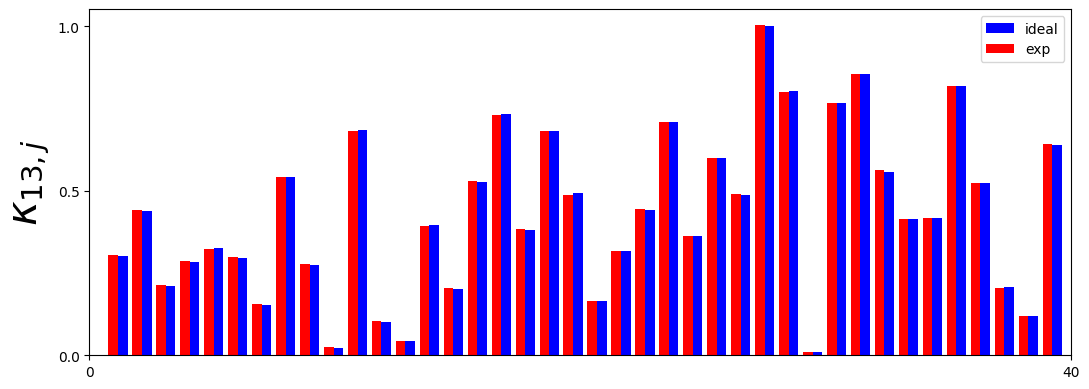

In [28]:
# mention in paper fig 4.b
fig = plt.subplots(figsize =(11, 4), tight_layout=True)
#bar width
width = 0.4
br = np.arange(len(k_ideal))
#plot bar
plt.bar(br+width, k_ideal[i], width, color ='b', label ='ideal')
plt.bar(br, k_exp[i]/shots, width, color ='r', label ='exp')

plt.ylabel(f'$\kappa_{{{(40-i)},j}}$', fontweight ='bold', fontsize = 30)
plt.yticks([0, 0.5, 1])
plt.xlim([0,br.size])
plt.xlim(left=-1)
plt.xticks([-1, 40], [0,40])
plt.legend()
# save image
if save_result == True: plt.savefig(f"{QKE_OUT}/{TEAM_NAME}_maxdev.png")
plt.show()

A cut through row i (indicated by black arrow) is shown above graph, where the ideal results are shown as blue bars, and experimental results are shown as red bars.   
*Note: Entries that are close zero in the kernel can become negative when the error-mitigation technique is applied.*

### Decision Boundary with custom function

Total grid size: 900


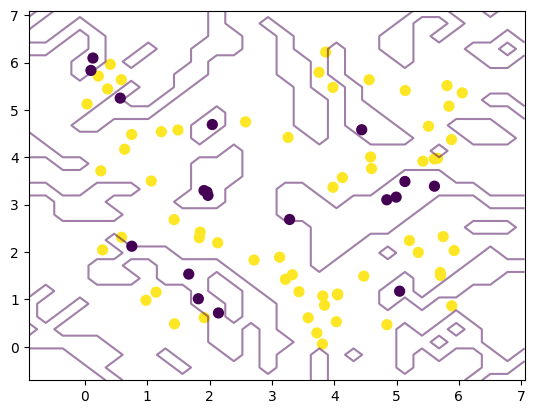

Time elapsed: 1738.882156610489s


In [29]:
def plot_decision_boundary(model, grid, ax=None):
    """
    run through a list of gred point, to plot decision boundary.
    
    Input:
        Model : Model function
        grid : number of grid, minimum 30
    
    Output:
        None
    """
    if ax is None:
        ax = plt.gca()
    xlim = (
        X_train[:, 0].min() - 1.0,
        X_train[:, 0].max() + 1.0,
    )
    ylim = (
            X_train[:, 1].min() - 1.0,
            X_train[:, 1].max() + 1.0,
        )
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], grid) # it give a grid to run through
    y = np.linspace(ylim[0], ylim[1], grid)
    Y, X = np.meshgrid(y, x)

    # shape data
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    print(f"Total grid size: {xy.shape[0]}")
    
    # get the decision boundary based on the model
    P = model(xy).reshape(X.shape)
    
    # plot decision boundary
    ax.contour(X, Y, P,
               levels=[0], alpha=0.5,
               linestyles=['-'])

start = time.time()
# plot data and decision boundary
plt.scatter(X_data[:, 0], X_data[:, 1], c=Y_data, s=50)
plot_decision_boundary(svmclassify,30,None) # minimum 30
plt.scatter(alpha, alpha, s=50, lw=1, facecolors='None')
if save_result == True: plt.savefig(f"{QKE_OUT}/{TEAM_NAME}_SDBB.png")
plt.show()
#total time taken
print(f"Time elapsed: {time.time() - start}s")

You have everything you need to plot the decision boundary for non-linear data.  
We can do that with a few lines of code that use the Matlibplot library, just like the other plots.  
Decision Binary Boundary with custom function, it will take lesser time, because it will run though a custom limit set of gred point.  

### Decision Boundary with mlxtend (take too much time, but better)

In [30]:
#start = time.time()
#!pip install mlxtend==0.21.0 -q
#from mlxtend.plotting import plot_decision_regions
#import matplotlib.gridspec as gridspec
#gs = gridspec.GridSpec(2, 2)
#class classifier():
#    def predict(x):
#        pred = svmclassify(x)
#        print('finish class')
#        return [1 if pred[i] == 1 else 0 for i in range(len(pred))]# convert -1 to 0, so it can show proper result
#fig = plot_decision_regions(X=numpy.array(X_train), y=numpy.array(Y_train, dtype=int), clf=classifier, legend=2, zoom_factor=1) #change zoom_factor, to zoom in or out
#plt.title("QSVM Decision Binary Boundary")
#if save_result == True: plt.savefig(f"{QKE_OUT}/{TEAM_NAME}_FDBB.png")
#plt.show()
#
##total time taken
#print(f"Time elapsed: {time.time() - start}s")

Decision Binary Boundary with mlxtend, it takes a lot of time, because it will run though a full set of grid data, but we can see a better visualization

### Total runtime

In [31]:
print(f"Notebook total time elapsed: {time.time() - notebook_start}s")

Notebook total time elapsed: 2205.6293449401855s


## Reference:
- [1] https://arxiv.org/pdf/1804.11326.pdf
- [2] https://github.com/sheethal10891/ML_IntelligentSystems/blob/master/Project%206:%20Kernels/python_HW6_KERNEL.ipynb
- [3] https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/machine_learning/custom_feature_map.ipynb